In [2]:
import xarray as xr
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_nc_data(root, file_name):
    """load nc data and select the region of interest
    
    Returns:
        data: a xr.dataarray of shape (time, lat, lon)
    """
    data_file = root + file_name
    var_name = 'aod'
    with xr.open_dataset(data_file) as data:
        data = data[var_name]
    return data.values

class NcDataset(Dataset):
    def __init__(self, root, file_name, n_frames_input, n_frames_output):
        super().__init__()
        self.datas = load_nc_data(root, file_name)
        self.num_frames_input = n_frames_input
        self.num_frames_output = n_frames_output
        self.num_frames = n_frames_input + n_frames_output
        print('Loaded {} samples'.format(self.__len__()))

    def __getitem__(self, idx):
#        data = self.datas[index:index+self.num_frames]
        data = self.datas[idx*self.num_frames:(idx+1)*self.num_frames]
        inputs = data[:self.num_frames_input]
        targets = data[self.num_frames_input:]
        inputs = inputs[..., np.newaxis]
        targets = targets[..., np.newaxis]
        # replace nan values with 0
        # inputs = np.nan_to_num(inputs)
        # targets = np.nan_to_num(targets)
        # replace negative values with 0
        inputs[inputs < 0] = 0.0
        targets[targets < 0] = 0.0
        inputs = torch.from_numpy(inputs).permute(0, 3, 1, 2).float().contiguous()
        targets = torch.from_numpy(targets).permute(0, 3, 1, 2).float().contiguous()
        return idx, targets, inputs
    

    def __len__(self):
        return self.datas.shape[0] // self.num_frames

In [4]:
data_set = NcDataset(root='./data/',
                        file_name='saved_aod_20230101_interp_cubic.nc',
                        n_frames_input=6,
                        n_frames_output=6)
batch_size = 5
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=False)
# print the shape of the first batch
for batch_ind, (i, targets, inputs) in enumerate(data_loader):
    print('batch_ind: {}'.format(batch_ind))
    print('i: {}'.format(i))
    print('targets: {}'.format(targets.shape))
    print('inputs: {}'.format(inputs.shape))
    break

Loaded 425 samples
batch_ind: 0
i: tensor([0, 1, 2, 3, 4])
targets: torch.Size([5, 6, 1, 64, 64])
inputs: torch.Size([5, 6, 1, 64, 64])


Using device cuda.
torch.Size([5, 6, 1, 64, 64]) torch.Size([5, 6, 1, 64, 64]) tensor(11.4774, device='cuda:0') tensor(0., device='cuda:0')


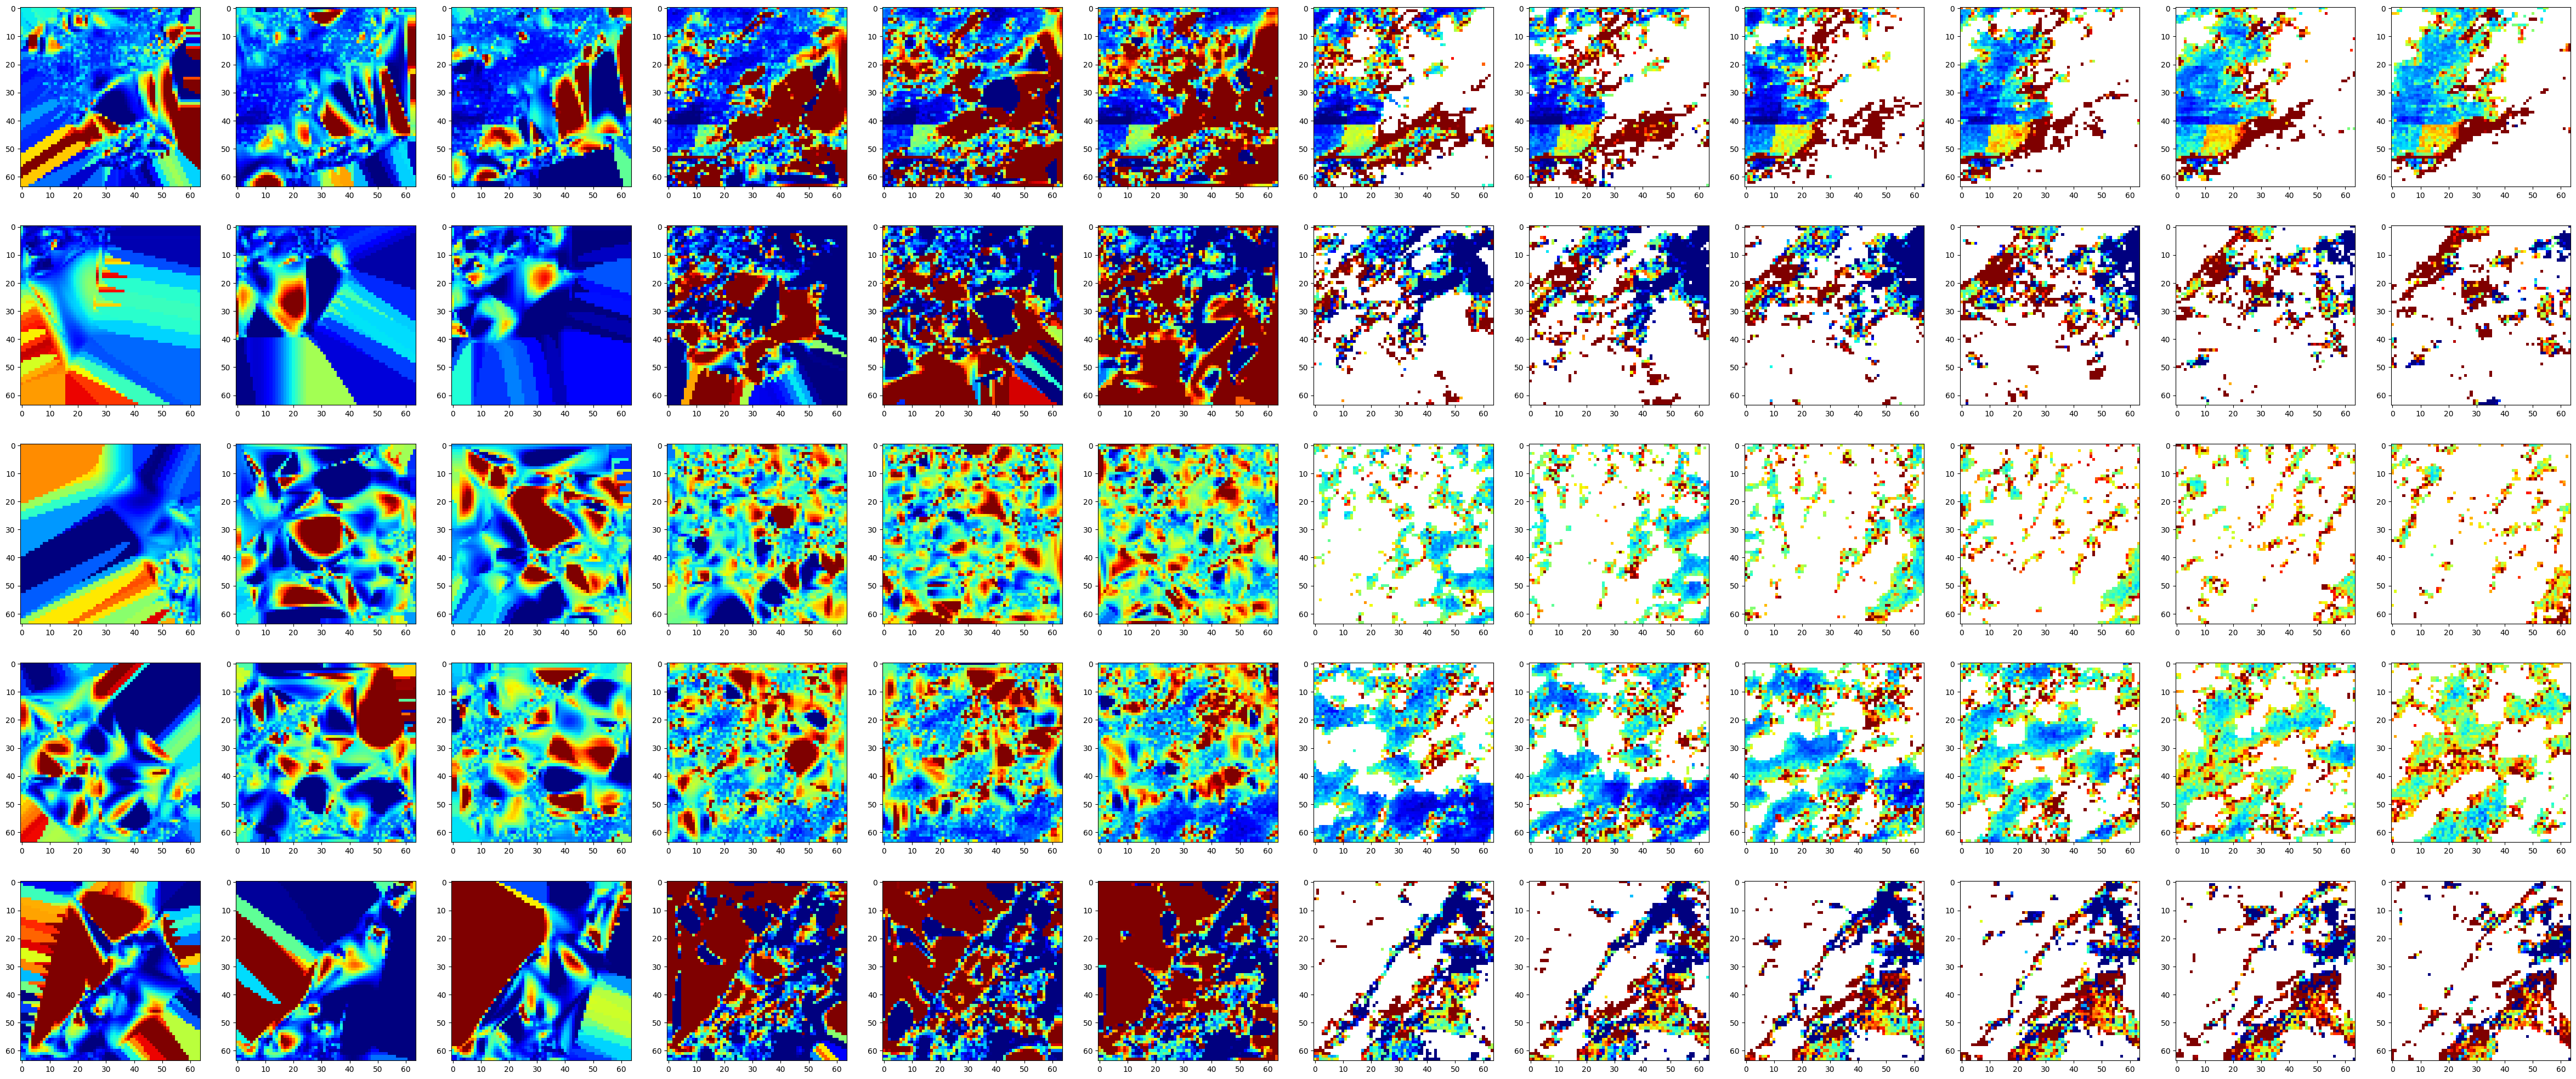

In [5]:
# choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device {}.".format(device))
# plot the first batch
for batch_idx, (i, targets, inputs) in enumerate(data_loader):
    inputs = inputs.float().to(device)
    targets = targets.float().to(device)
    print(inputs.shape, targets.shape, inputs.max(), inputs.min())
    images = torch.cat([inputs, targets], dim=1)
    _, axarr = plt.subplots(images.shape[0], images.shape[1], figsize=(images.shape[1]*batch_size, images.shape[0]*batch_size))
    for b in range(images.shape[0]):
        for n in range(images.shape[1]):
            plot_img = images[b, n, 0].cpu().numpy()
            axarr[b][n].imshow(np.flip(plot_img, axis=0), cmap='jet', vmin=0, vmax=0.2)
    break

In [6]:
# load the trained model
import os
from encoder import Encoder
from decoder import Decoder
from model import ED
from net_params import convlstm_encoder_params, convlstm_decoder_params, convgru_encoder_params, convgru_decoder_params


def load_model(base_cell='convgru'):
    TIMESTAMP = "2023-09-16"
    checkpoints_dir = f'save_model/{TIMESTAMP}_{base_cell}/'
    all_checkpoints = os.listdir(checkpoints_dir)
    all_checkpoints.sort()
    # get the lowest loss checkpoint
    losses = []
    for checkpoint in all_checkpoints:
        loss = checkpoint.split('_')[-1][:8]
        losses.append(float(loss))
    lowest_loss_checkpoint = all_checkpoints[np.argmin(losses)]
    print(lowest_loss_checkpoint)

    # initialize the network
    if base_cell == 'convlstm':
        convlstm_bool = True
    elif base_cell == 'convgru':
        convlstm_bool = False
    else:
        raise ValueError(f"Invalid base cell: {base_cell}")
    encoder_params = convlstm_encoder_params if convlstm_bool else convgru_encoder_params
    decoder_params = convlstm_decoder_params if convlstm_bool else convgru_decoder_params
    encoder = Encoder(encoder_params[0], encoder_params[1]).to(device)
    decoder = Decoder(decoder_params[0], decoder_params[1]).to(device)
    net = ED(encoder, decoder)
    net = net.to(device)
    # load the checkpoint
    model_info = torch.load(os.path.join(checkpoints_dir, lowest_loss_checkpoint))
    net.load_state_dict(model_info['state_dict'])
    return net

In [7]:
# perform inference and save the results
net_gru = load_model(base_cell='convgru')
net_lstm = load_model(base_cell='convlstm')
for batch_idx, (i, targets, inputs) in enumerate(data_loader):
    # only do the first 20 batches (100 samples)
    if batch_idx == 20:
        break
    print('batch_idx: {}'.format(batch_idx))
    inputs = inputs.float().to(device)
    targets = targets.float().to(device)
    outputs_gru = net_gru(inputs)
    outputs_lstm = net_lstm(inputs)
    # save to file (npy format)
    save_inputs = inputs.cpu().detach().numpy().squeeze(2).reshape(-1, 64, 64)
    save_outputs_gru = outputs_gru.cpu().detach().numpy().squeeze(2).reshape(-1, 64, 64)
    save_outputs_lstm = outputs_lstm.cpu().detach().numpy().squeeze(2).reshape(-1, 64, 64)
    np.save('./data/save_inputs_{}-{}.npy'.format(batch_idx*batch_size, (batch_idx+1)*batch_size-1), save_inputs)
    np.save('./data/save_outputs_gru_{}-{}.npy'.format(batch_idx*batch_size, (batch_idx+1)*batch_size-1), save_outputs_gru)
    np.save('./data/save_outputs_lstm_{}-{}.npy'.format(batch_idx*batch_size, (batch_idx+1)*batch_size-1), save_outputs_lstm)
    print('saved batch {}-{}'.format(batch_idx*batch_size, (batch_idx+1)*batch_size-1))

checkpoint_10_0.000606.pth.tar
checkpoint_10_0.000476.pth.tar
batch_idx: 0
saved batch 0-4
batch_idx: 1
saved batch 5-9
batch_idx: 2
saved batch 10-14
batch_idx: 3
saved batch 15-19
batch_idx: 4
saved batch 20-24
batch_idx: 5
saved batch 25-29
batch_idx: 6
saved batch 30-34
batch_idx: 7
saved batch 35-39
batch_idx: 8
saved batch 40-44
batch_idx: 9
saved batch 45-49
batch_idx: 10
saved batch 50-54
batch_idx: 11
saved batch 55-59
batch_idx: 12
saved batch 60-64
batch_idx: 13
saved batch 65-69
batch_idx: 14
saved batch 70-74
batch_idx: 15
saved batch 75-79
batch_idx: 16
saved batch 80-84
batch_idx: 17
saved batch 85-89
batch_idx: 18
saved batch 90-94
batch_idx: 19
saved batch 95-99


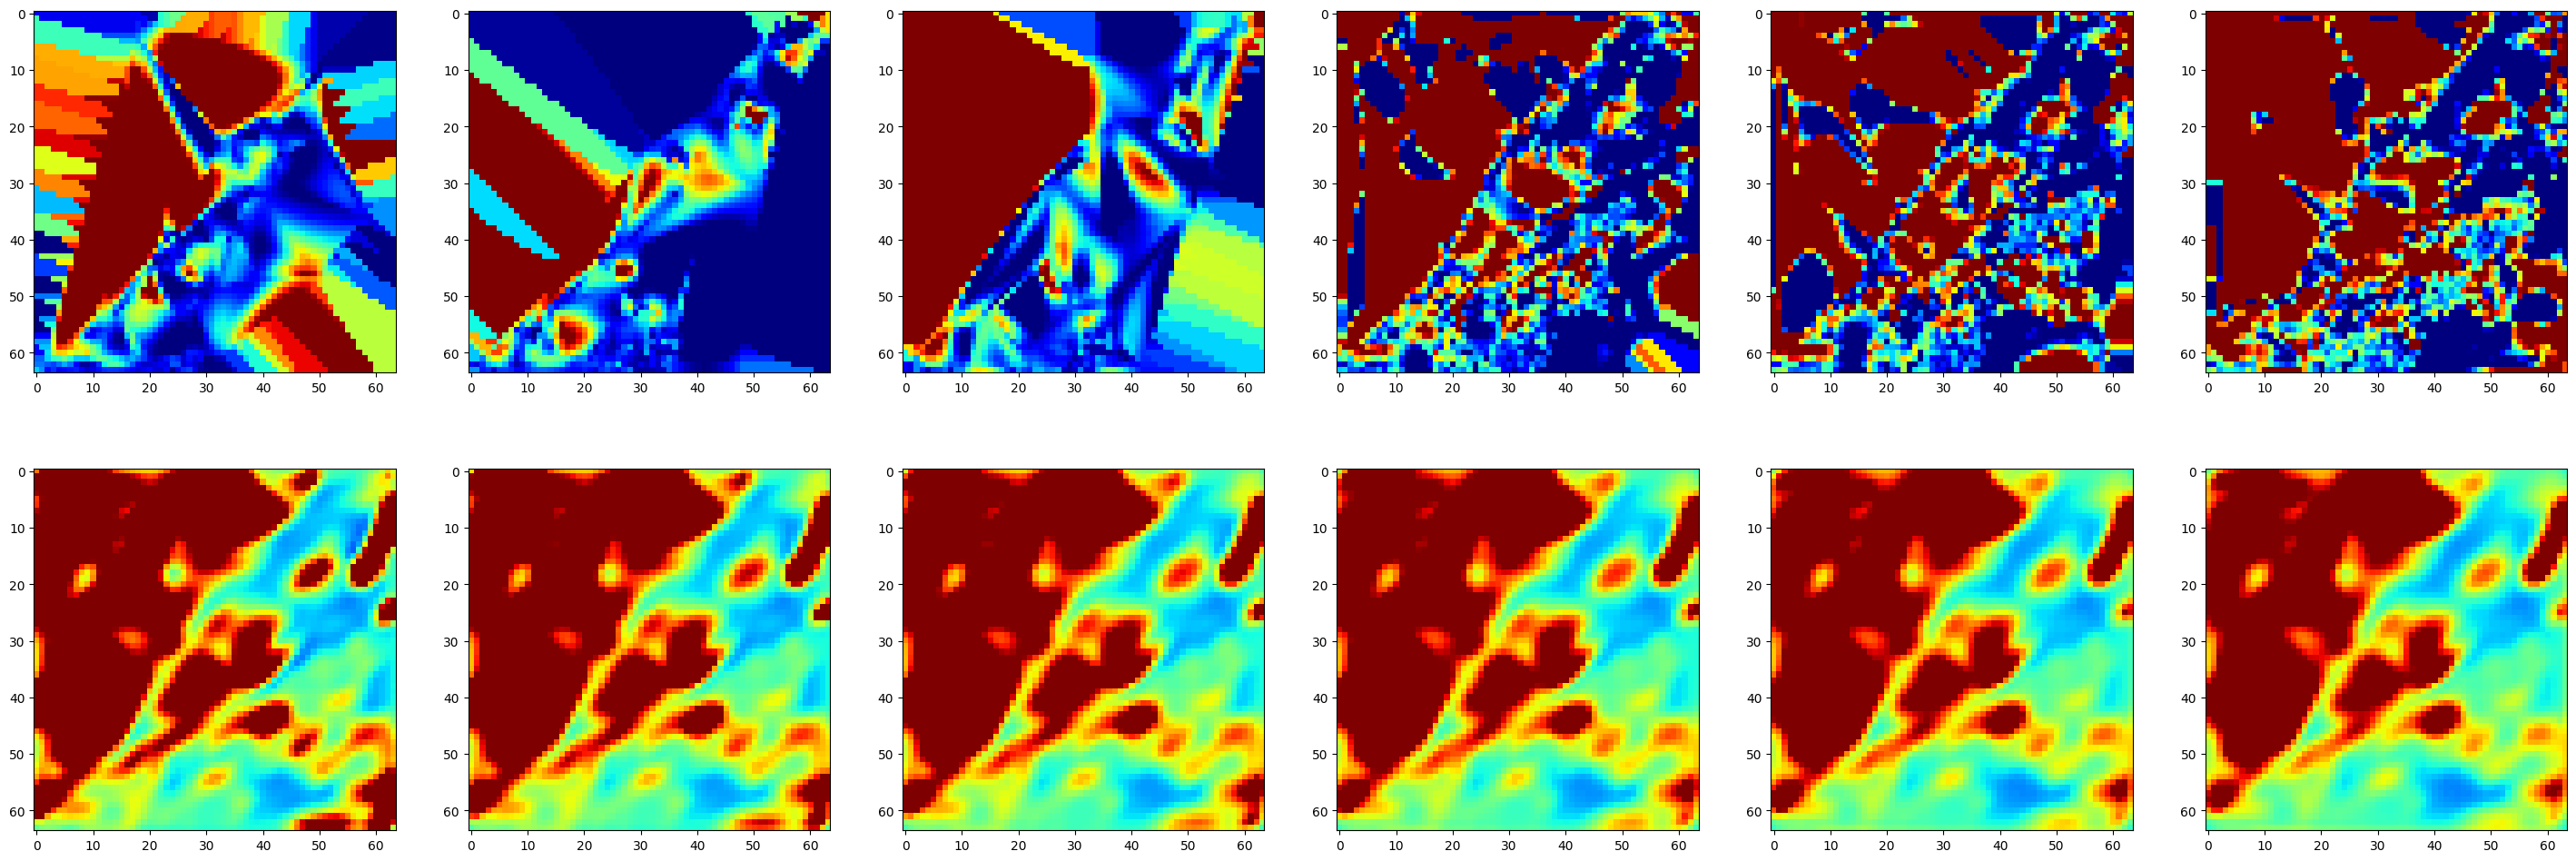

In [8]:
# plot some sample
to_plot_sample_idx = 4 # define which sample to plot, this will plot the 5th (index=4) sample
# load inputs and model predictions
save_inputs_data = np.load('./data/save_inputs_0-4.npy')
save_gru_data = np.load('./data/save_outputs_gru_0-4.npy')
save_lstm_data = np.load('./data/save_outputs_lstm_0-4.npy')

save_inputs_data = save_inputs_data[to_plot_sample_idx*6:(to_plot_sample_idx+1)*6, ...]
save_gru_data = save_gru_data[to_plot_sample_idx*6:(to_plot_sample_idx+1)*6, ...]
plot_data = np.concatenate((save_inputs_data, save_gru_data), axis=0)

_, axarr = plt.subplots(2, 6, figsize=(6*6, 2*6))
for n in range(6):
    plot_img = plot_data[n, ...]
    axarr[0][n].imshow(np.flip(plot_img, axis=0), cmap='jet', vmin=0, vmax=0.2)
    plot_img = plot_data[n+6, ...]
    axarr[1][n].imshow(np.flip(plot_img, axis=0), cmap='jet', vmin=0, vmax=0.2)
# close the figure
plt.show()